# DBSCAN (Density-Based Spatial Clustering of Aplication with Noise)

+ Clustering basado en desidad.
+ Su principio se basa en que un cluster tiene alta densidad, mientras que la región que los separa nola tiene.
+ La idea pricipal es que cada punto del cluster de acuerdo a un radio dado debe tener un mínimo de vecinos o puntos cercanos para encontrar densidad.
+ Requiero dos parámetros -> eps(epsilon) MinPts(Minimo de puntos aceptables en el cluster).

![DBSCAN_parametros](./img/DBSCAN_parametros.png)

+ No trabaja unicamente con formas esfeicas como Kmeans para crear los clusters.

![DBSCAN_formas](./img/DBSCAN_formas.png)


Se puede dar tres escenarios cuando se crean los clusters
+ **Core Point**: Eres un punto que en el vecindario que se cumple con la cantidad o mas con los puntos minimos establecidos.
+ **Border Point**: Punto que no tienen la cantidad minima de puntos estanblecida pero que tiene vecindad con algunos de ellos.
+ **Noise**: Punto que representa ruido.

![DBSCAN_escenarios](./img/DBSCAN_escenarios.png)

+ Cuando un Core Point conecta con otro Core Point se suma del mismo cluster y si esta conecta con otro de estos lo va agregando al cluster, luego empieza busca conectar con los Border Point.
+ Tamaños muy pequeños del epsilon hace que el algorintmo tarde mucho o que cree muchos cluster inecesarios o si es muy grnades que nunca converja

## Ventajas
+ No requeire especificar el número de clusters.
+ Es capaz de detectar outliers o ruido.
+ Puede encontrar clusters en formas y tamaños arbitrarios.

## Desventajas
+ Los hiper-parámetros son muy determinantes, algunas combinaciones no funcionan igual para todos los grupos con distintas densidades.
+ Los puntos fronterizos a los que puede acceder desde más de un cluster pueden formar parte de cualquier cluster.

## ¿Cuando usarlo? 

+ Desconozco la cantidad de clusters.
+ No uso formas esféricas.
+ Densidad similares entre clusters

## Importar librerias

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Preparando datos de prueba

In [11]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2,return_centers=True)

df_blobs = pd.DataFrame(
    {
        'x1': X[:,0],
        'x2': X[:,1]
    }
)

df_centers = pd.DataFrame(
    {
        'x1': c[:,0],
        'x2': c[:,1],
    }
)

In [12]:
X_m ,y_m = make_moons(n_samples=250, noise=0.05, random_state=42)

df_moons = pd.DataFrame(
    {
        'x1': X_m[:,0],
        'x2': X_m[:,1]
    }
    )

## Visualización de datos

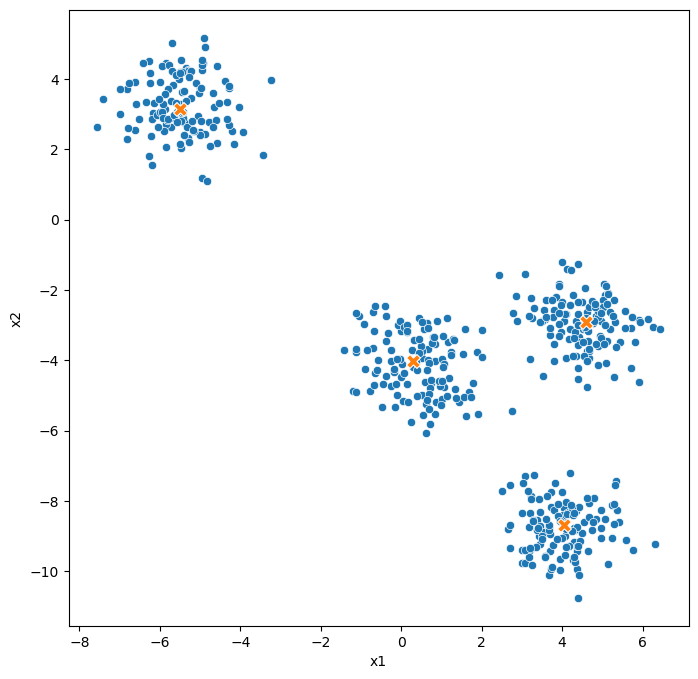

In [13]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s = 100)
plt.plot()
plt.show()

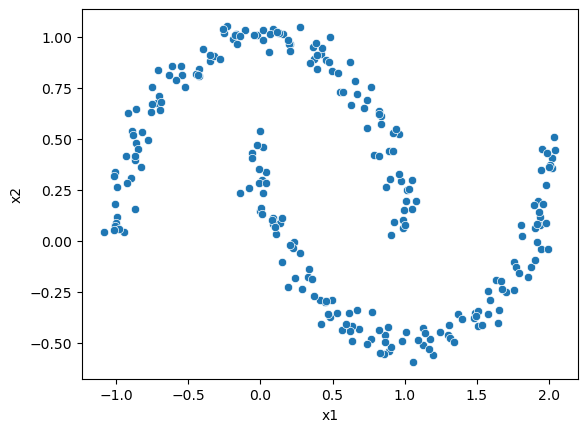

In [14]:
sns.scatterplot(data=df_moons, x='x1', y='x2')
plt.show()

## Implementado DBSCAN

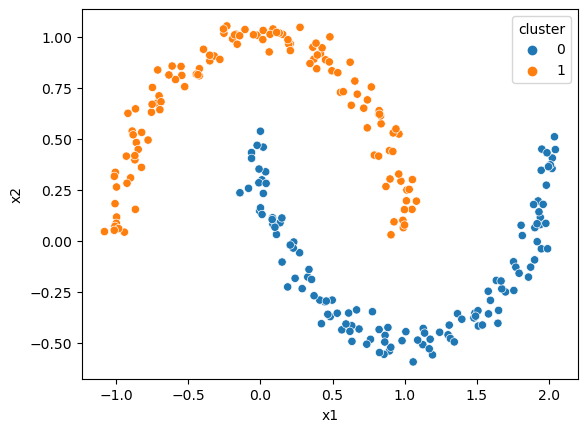

In [15]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=3)
y_m_predict = dbscan_cluster.fit_predict(X_m)
df_moons['cluster'] = y_m_predict
sns.scatterplot(data=df_moons, x='x1', y='x2', hue='cluster')
plt.show()

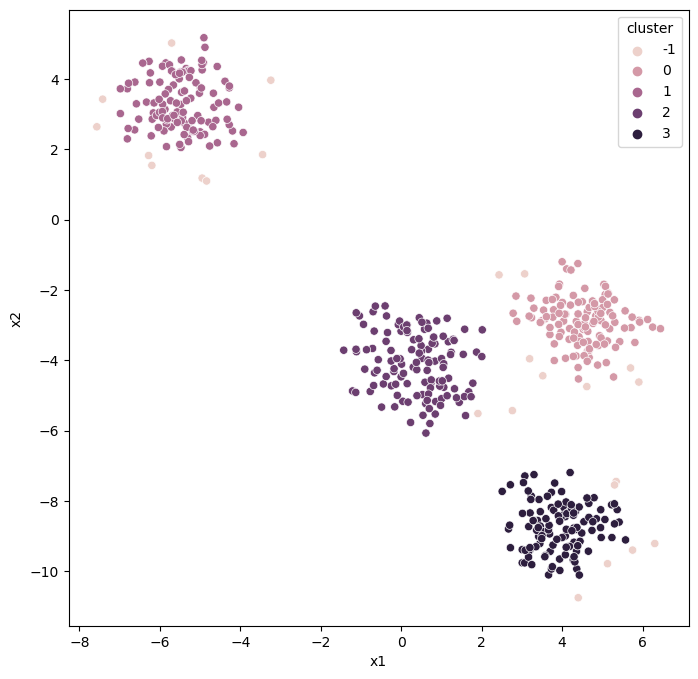

In [22]:
dbscan = DBSCAN(eps=0.5, min_samples=4)
y_predict = dbscan.fit_predict(X)
df_blobs['cluster'] = y_predict

fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster')
plt.plot()
plt.show()